In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.insert(0,os.path.join(os.path.abspath('../')))
import prieml

In [4]:
data_pth = os.path.join(os.path.abspath('../'), 'dataset')
data_pth

'/mnt/orisenbazuru/PE_webapp/dataset'

### Read hyongbum dataset

In [5]:
df = pd.read_csv(os.path.join(data_pth, 'hyongbum_raw', '20210902_Hyongbum_HT_Train_pegRNA_features_traintestsplit.csv'))

In [6]:
df[['original_base_mt','edited_base_mt', 'EDIT_EFFICIENCY', 'deepeditposition', 'traintest']]

,original_base_mt,edited_base_mt,EDIT_EFFICIENCY,deepeditposition,traintest
0,4,4,25.045634,25,HT-Training
1,4,4,29.794371,25,HT-Training
2,4,4,30.959833,25,HT-Training
3,4,4,30.650768,25,HT-Training
4,4,4,27.619501,25,HT-Training
...,...,...,...,...,...
43144,4,4,0.438796,25,HT-Training
43145,4,4,2.334892,25,HT-Training
43146,4,4,2.051988,25,HT-Training
43147,4,4,1.505476,25,HT-Training


In [7]:
df['original_base_mt_nan'] = 0.
df['edited_base_mt_nan'] = 0.

In [8]:
df['traintest'].value_counts()

HT-Training    38692
HT-Test         4457
Name: traintest, dtype: int64

In [9]:
from prieml.utilities import check_na
check_na(df)

In [10]:
df['y'] = df['EDIT_EFFICIENCY']/100.
df['averageedited'] = df['y']
df['Editing_Position'] = df['deepeditposition']

In [11]:
df['seq_id'] = [f'seq_{i}' for i in range(df.shape[0])] # assign unique id under seq_id column -- very important

In [12]:
# min_val = df['y'].min()
# max_val = df['y'].max()
# df['y'] = (df['y'] - min_val)/(max_val-min_val)

In [13]:
df_train = df.loc[df['traintest'] == 'HT-Training'].copy()

In [14]:
df_test = df.loc[df['traintest'] == 'HT-Test'].copy()

<AxesSubplot:>

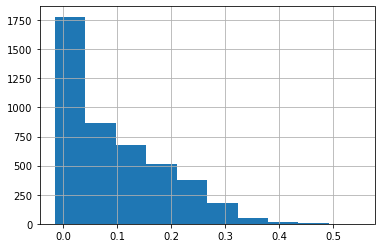

In [15]:
df_test['y'].hist()

In [16]:
from prieml.predict_outcomedistrib import *
from prieml.utilities import *

In [17]:
from prieml.utilities import get_device, compute_pearson_corr, compute_spearman_corr

### Instantiate model

In [18]:
# trained model directory
model_dir = os.path.join(os.path.abspath('../'), 
                         'trained_models', 
                         'schwank_rnnattn', 
                         'v3', 
                         'train_val')

device = get_device(True,0)
prieml_model = PRIEML_Model(device,wsize=20, normalize='max', fdtype=torch.float32)

tcol = 'averageedited'
res_lst = []
for wsize in [20]:
    prieml_model.wsize = wsize
    dloader = prieml_model.prepare_data(df_test, y_ref=[tcol], batch_size=1500)
    pred_lst=[]
    for run in range(5):
        # predict
        mdir = os.path.join(model_dir, f'run_{run}')
        pred_df = prieml_model.predict_from_dloader(dloader, mdir, y_ref=[tcol])
        pred_lst.append(pred_df)
        pear_score = compute_pearson_corr(pred_df[f'true_{tcol}'],pred_df[f'pred_{tcol}'])[0]
        spear_score = compute_spearman_corr(pred_df[f'true_{tcol}'], pred_df[f'pred_{tcol}'])[0]
        print('pearson corr:', pear_score)
        print('spearman corr:',spear_score)
        res_lst.append((wsize, run, pear_score, spear_score))
        print('-'*15)
        
    pred_df = pd.concat(pred_lst, axis=0, ignore_index=True)
    pred_df = prieml_model.compute_avg_predictions(pred_df)
    print('wsize:', wsize)

    
    pear_score = compute_pearson_corr(pred_df[f'true_{tcol}'],pred_df[f'pred_{tcol}'])[0]
    spear_score = compute_spearman_corr(pred_df[f'true_{tcol}'], pred_df[f'pred_{tcol}'])[0]
    print('pearson corr:', pear_score)
    print('spearman corr:',spear_score)
    res_lst.append((wsize, 'avg_runs', pear_score, spear_score))
    print('-'*15)

res_df = pd.DataFrame(res_lst)
res_df.columns = ['wsize', 'run','pear_score', 'spearman_score']

--- processing input data frame ---
--- creating correction type categories ---


  0%|          | 0/4 [00:00<?, ?it/s]
10it [00:00, 10.91it/s]                      
 25%|██▌       | 1/4 [00:00<00:02,  1.09it/s]

processing: protospacerlocation_only_initial



100%|██████████| 4457/4457 [00:00<00:00, 695435.92it/s]


processing: PBSlocation



100%|██████████| 4457/4457 [00:00<00:00, 709692.61it/s]


processing: RT_initial_location



100%|██████████| 4457/4457 [00:00<00:00, 711935.90it/s]

  0%|          | 0/4 [00:00<?, ?it/s]
10it [00:00, 10.90it/s]                      
6it [00:01,  3.48it/s]                       

processing: PBSlocation



100%|██████████| 4457/4457 [00:00<00:00, 696394.46it/s]


processing: RT_mutated_location



100%|██████████| 4457/4457 [00:00<00:00, 695927.81it/s]
10it [00:01,  5.07it/s]


--- normalizing continuous features ---
--- max normalization ---
--- creating datatensor ---
--- create_datatensor ---
X_init_nucl.unique(): tensor([0, 1, 2, 3])
ntoken_cond: tensor([False])
X_init_proto: tensor([0, 1])
X_init_pbs: tensor([0, 1])
X_init_rt: tensor([0, 1])
X_mut_nucl.unique(): tensor([0, 1, 2, 3])
ntoken_cond: tensor([False])
X_mut_pbs: tensor([0, 1])
X_mut_rt: tensor([0, 1])
ycols: ['averageedited']
--- creating datatloader ---
--- loading model config ---
--- building model ---
--- loading trained model ---


3it [00:00,  5.10it/s]


pearson corr: 0.43438159594597725
spearman corr: 0.5052653863159363
---------------
--- loading model config ---
--- building model ---
--- loading trained model ---


3it [00:00,  4.57it/s]


pearson corr: 0.43815125439948754
spearman corr: 0.5020703640066124
---------------
--- loading model config ---
--- building model ---
--- loading trained model ---


3it [00:00,  4.67it/s]


pearson corr: 0.4109490352647435
spearman corr: 0.47916159674517045
---------------
--- loading model config ---
--- building model ---
--- loading trained model ---


3it [00:00,  5.17it/s]


pearson corr: 0.4601431777205105
spearman corr: 0.5412166091455605
---------------
--- loading model config ---
--- building model ---
--- loading trained model ---


3it [00:00,  4.59it/s]


pearson corr: 0.4398662105675246
spearman corr: 0.5150682570056092
---------------
wsize: 20
pearson corr: 0.46140995771869375
spearman corr: 0.5461304265360176
---------------


In [19]:
pred_df

,seq_id,true_averageedited,pred_averageedited,pred_averageunedited,pred_averageindel
0,seq_100,-0.000690,0.472105,0.490694,0.037201
1,seq_1000,0.050382,0.518670,0.434267,0.047064
2,seq_1001,0.058304,0.635905,0.328002,0.036092
3,seq_1002,0.138959,0.786720,0.179731,0.033548
4,seq_1003,0.067282,0.569740,0.284155,0.146104
...,...,...,...,...,...
4452,seq_9982,-0.000033,0.321970,0.653145,0.024885
4453,seq_9983,0.000000,0.095458,0.891060,0.013482
4454,seq_9984,0.000000,0.210023,0.747614,0.042363
4455,seq_9985,0.000376,0.276023,0.674550,0.049427


In [20]:
res_df

,wsize,run,pear_score,spearman_score
0,20,0,0.434382,0.505265
1,20,1,0.438151,0.502070
2,20,2,0.410949,0.479162
3,20,3,0.460143,0.541217
4,20,4,0.439866,0.515068
5,20,avg_runs,0.461410,0.546130


### Visualizing sequences

In [21]:
viz_tup = prieml_model.prepare_df_for_viz(df_test)

--- processing input data frame ---
--- creating correction type categories ---


  0%|          | 0/4 [00:00<?, ?it/s]
10it [00:00, 10.69it/s]                      
 25%|██▌       | 1/4 [00:00<00:02,  1.07it/s]

processing: protospacerlocation_only_initial



100%|██████████| 4457/4457 [00:00<00:00, 685289.52it/s]


processing: PBSlocation



100%|██████████| 4457/4457 [00:00<00:00, 705088.56it/s]


processing: RT_initial_location



100%|██████████| 4457/4457 [00:00<00:00, 704291.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]
10it [00:00, 10.89it/s]                      
6it [00:01,  3.44it/s]                       

processing: PBSlocation



100%|██████████| 4457/4457 [00:00<00:00, 697772.12it/s]


processing: RT_mutated_location



100%|██████████| 4457/4457 [00:00<00:00, 700255.20it/s]
10it [00:01,  5.04it/s]

--- normalizing continuous features ---
--- max normalization ---


In [22]:
from IPython.core.display import HTML

In [23]:
# choose ids of sequences to visualize
# we are using seq_id as the main column to filter from 
viz_res = prieml_model.visualize_seqs(viz_tup, ['seq_92','seq_93', 'seq_5557', 'seq_5654', 'seq_5658', 'seq_7883'])
for kelm in viz_res:
    display(HTML(viz_res[kelm]))

100%|██████████| 6/6 [00:00<00:00, 118.91it/s]

start_seq: 0
ewindow_st: 25
start_seq: 0
ewindow_st: 25
start_seq: 0
ewindow_st: 25
start_seq: 0
ewindow_st: 25
start_seq: 0
ewindow_st: 25
start_seq: 0
ewindow_st: 25


Seq. ID:seq_93,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,
Initial sequence,A,A,A,A,C,T,T,T,G,C,A,C,T,T,A,T,A,G,C,C,T,C,G,C,T,G,G,G,T,A,A,G,G,C,T,G,T,C,A,C,C,C,C,A,G,C,T
Mutated sequence Prob. edit=0.000,A,A,A,A,C,T,T,T,G,C,A,C,T,T,A,T,A,G,C,C,T,C,G,C,T,C,G,G,T,A,A,G,G,C,T,G,T,C,A,C,C,C,C,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,


Seq. ID:seq_5557,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,
Initial sequence,A,G,C,A,G,T,T,C,C,T,T,C,T,A,G,A,G,A,A,G,C,T,G,A,A,G,G,T,A,A,G,C,C,T,G,T,T,A,C,T,T,G,A,A,G,C,T
Mutated sequence Prob. edit=0.403,A,G,C,A,G,T,T,C,C,T,T,C,T,A,G,A,G,A,A,G,C,T,G,A,A,C,G,T,A,A,G,C,C,T,G,T,T,A,C,T,T,G,A,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,


Seq. ID:seq_5658,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,
Initial sequence,A,G,C,C,C,C,A,T,G,G,G,G,T,G,G,C,C,T,T,C,C,A,G,C,A,G,G,C,A,T,G,G,A,C,A,G,G,G,C,G,T,G,G,A,G,C,T
Mutated sequence Prob. edit=0.466,A,G,C,C,C,C,A,T,G,G,G,G,T,G,G,C,C,T,T,C,C,A,G,C,A,C,G,C,A,T,G,G,A,C,A,G,G,G,C,G,T,G,G,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,


Seq. ID:seq_7883,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,
Initial sequence,A,G,T,T,G,A,T,G,A,C,A,G,T,C,C,A,A,G,C,A,C,T,A,G,T,G,G,A,G,G,A,A,G,T,T,C,C,G,A,T,G,G,A,A,G,C,T
Mutated sequence Prob. edit=0.424,A,G,T,T,G,A,T,G,A,C,A,G,T,C,C,A,A,G,C,A,C,T,A,G,T,C,G,A,G,G,A,A,G,T,T,C,C,G,A,T,G,G,A,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,


Seq. ID:seq_5654,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,,,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,
Initial sequence,A,G,C,C,C,C,A,T,G,G,G,G,T,G,G,C,C,T,T,C,C,A,G,C,A,G,G,C,A,T,G,G,A,C,A,G,G,G,C,G,T,G,G,A,G,C,T
Mutated sequence Prob. edit=0.548,A,G,C,C,C,C,A,T,G,G,G,G,T,G,G,C,C,T,T,C,C,A,G,C,A,C,G,C,A,T,G,G,A,C,A,G,G,G,C,G,T,G,G,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,,,,,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,


Seq. ID:seq_92,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
Protos,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,
Initial sequence,A,A,A,A,C,T,T,T,G,C,A,C,T,T,A,T,A,G,C,C,T,C,G,C,T,G,G,G,T,A,A,G,G,C,T,G,T,C,A,C,C,C,C,A,G,C,T
Mutated sequence Prob. edit=-0.002,A,A,A,A,C,T,T,T,G,C,A,C,T,T,A,T,A,G,C,C,T,C,G,C,T,C,G,G,T,A,A,G,G,C,T,G,T,C,A,C,C,C,C,A,G,C,T
Editing: Replacement,,,,,,,,,,,,,,,,,,,,,,,,,,*,,,,,,,,,,,,,,,,,,,,,
PBS,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,,,,,,,,,,,,,,,,
RT,,,,,,,,,,,,,,,,,,,,,,*,*,*,*,*,*,*,*,*,*,*,*,*,*,*,,,,,,,,,,,
